In [1]:
import pandas as pd
import numpy as np

np.random.seed(37)

df = pd.DataFrame({
    'p': np.arange(1, 20, 1) + 1.99,
    'q': np.exp(-0.1 * np.arange(1, 20, 1)) * 100.0 
})

df

,p,q
0,2.99,90.483742
1,3.99,81.873075
2,4.99,74.081822
3,5.99,67.032005
4,6.99,60.653066
5,7.99,54.881164
6,8.99,49.658530
7,9.99,44.932896
8,10.99,40.656966
9,11.99,36.787944


<Axes: title={'center': 'Price vs Quantity'}, xlabel='p', ylabel='q'>

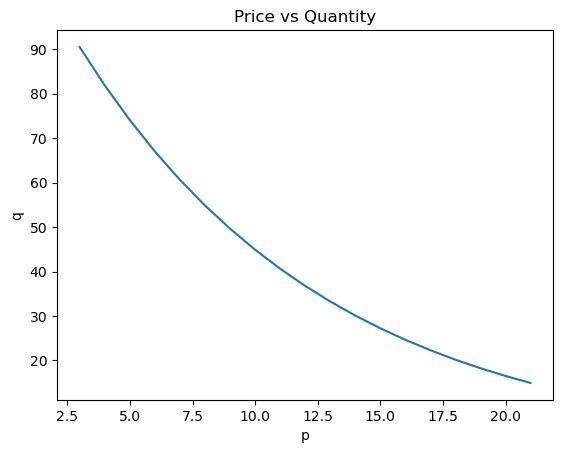

In [2]:
df.set_index(['p'])['q'].plot(kind='line', ylabel='q', title='Price vs Quantity')

## Elasticity

In [3]:
_temp1 = df \
    .assign(
        q_n=lambda d: d['q'].shift(1),
        p_n=lambda d: d['p'].shift(1)
    ) \
    .dropna() \
    .assign(
        d_q=lambda d: d['q'] - d['q_n'],
        d_p=lambda d: d['p'] - d['p_n'],
        num=lambda d: d['d_q'] / d['q'],
        den=lambda d: d['d_p'] / d['p'],
        ped=lambda d: d['num'] / d['den']
    )

In [4]:
_temp2 = df \
    .assign(
        q_p=lambda d: d['q'].shift(-1),
        p_p=lambda d: d['p'].shift(-1)
    ) \
    .dropna() \
    .assign(
        d_q=lambda d: d['q'] - d['q_p'],
        d_p=lambda d: d['p'] - d['p_p'],
        num=lambda d: d['d_q'] / d['q'],
        den=lambda d: d['d_p'] / d['p'],
        ped=lambda d: d['num'] / d['den']
    )

<Axes: xlabel='p', ylabel='q'>

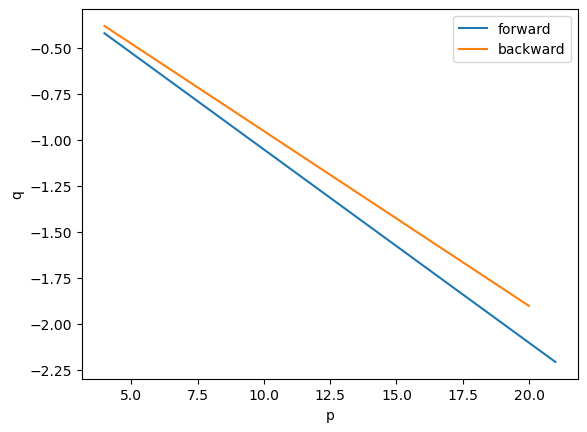

In [21]:
_temp1.set_index(['p']).rename(columns={'ped': 'forward'})[['forward']] \
    .join(_temp2.set_index(['p']).rename(columns={'ped': 'backward'})[['backward']]) \
    .plot(kind='line', ylabel='q')

## Arc elasticity

In [6]:
_temp3 = df \
    .assign(
        q_n=lambda d: d['q'].shift(1),
        p_n=lambda d: d['p'].shift(1)
    ) \
    .dropna() \
    .assign(
        d_q=lambda d: d['q'] - d['q_n'],
        d_p=lambda d: d['p'] - d['p_n'],
        ped=lambda d: (d['p'] + d['p_n']) / (d['q'] + d['q_n']) * (d['d_q'] / d['d_p'])
    )

In [7]:
_temp4 = df \
    .assign(
        q_n=lambda d: d['q'].shift(-1),
        p_n=lambda d: d['p'].shift(-1)
    ) \
    .dropna() \
    .assign(
        d_q=lambda d: d['q'] - d['q_n'],
        d_p=lambda d: d['p'] - d['p_n'],
        ped=lambda d: (d['p'] + d['p_n']) / (d['q'] + d['q_n']) * (d['d_q'] / d['d_p'])
    )

<Axes: xlabel='p', ylabel='q'>

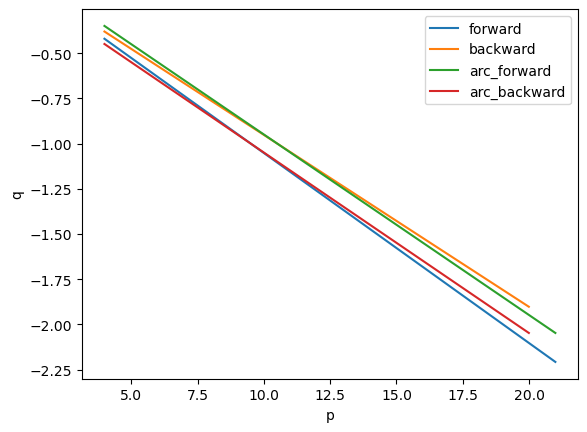

In [24]:
_temp1.set_index(['p']).rename(columns={'ped': 'forward'})[['forward']] \
    .join(_temp2.set_index(['p']).rename(columns={'ped': 'backward'})[['backward']]) \
    .join(_temp3.set_index(['p']).rename(columns={'ped': 'arc_forward'})[['arc_forward']]) \
    .join(_temp4.set_index(['p']).rename(columns={'ped': 'arc_backward'})[['arc_backward']]) \
    .plot(kind='line', ylabel='q')

In [9]:
_temp3

,p,q,q_n,p_n,d_q,d_p,ped
1,3.99,81.873075,90.483742,2.99,-8.610666,1.0,-0.348709
2,4.99,74.081822,81.873075,3.99,-7.791253,1.0,-0.448626
3,5.99,67.032005,74.081822,4.99,-7.049817,1.0,-0.548543
4,6.99,60.653066,67.032005,5.99,-6.378939,1.0,-0.648460
5,7.99,54.881164,60.653066,6.99,-5.771902,1.0,-0.748376
6,8.99,49.658530,54.881164,7.99,-5.222633,1.0,-0.848293
7,9.99,44.932896,49.658530,8.99,-4.725634,1.0,-0.948210
8,10.99,40.656966,44.932896,9.99,-4.275930,1.0,-1.048127
9,11.99,36.787944,40.656966,10.99,-3.869022,1.0,-1.148043
10,12.99,33.287108,36.787944,11.99,-3.500836,1.0,-1.247960


In [10]:
_temp4

,p,q,q_n,p_n,d_q,d_p,ped
0,2.99,90.483742,81.873075,3.99,8.610666,-1.0,-0.348709
1,3.99,81.873075,74.081822,4.99,7.791253,-1.0,-0.448626
2,4.99,74.081822,67.032005,5.99,7.049817,-1.0,-0.548543
3,5.99,67.032005,60.653066,6.99,6.378939,-1.0,-0.648460
4,6.99,60.653066,54.881164,7.99,5.771902,-1.0,-0.748376
5,7.99,54.881164,49.658530,8.99,5.222633,-1.0,-0.848293
6,8.99,49.658530,44.932896,9.99,4.725634,-1.0,-0.948210
7,9.99,44.932896,40.656966,10.99,4.275930,-1.0,-1.048127
8,10.99,40.656966,36.787944,11.99,3.869022,-1.0,-1.148043
9,11.99,36.787944,33.287108,12.99,3.500836,-1.0,-1.247960
